**Header Files and Imports**

In [66]:
# Enable inline plotting in Google Colab
%matplotlib inline

# Import necessary libraries
from sys import float_info  # Threshold smallest positive floating value
from math import ceil, floor
import matplotlib.pyplot as plt  # For general plotting
import numpy as np

# Import specific functions and classes
from scipy.optimize import minimize
from scipy.stats import multivariate_normal as mvn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_curve

**Plot Configuration and Global Settings**

In [67]:
# Set options for numpy to display numbers without scientific notation
np.set_printoptions(suppress=True)

# Set a random seed for reproducibility
np.random.seed(7)

# Set global plotting configurations for better visualization
# Font size of the title
plt.rc('axes', titlesize=20)
# Font size for text
plt.rc('font', size=24)
# Font size for the x and y labels
plt.rc('axes', labelsize=18)
# Font size of the x axes tick labels
plt.rc('xtick', labelsize=16)
# Font size of the y axes tick labels
plt.rc('ytick', labelsize=16)
# Legend fontsize
plt.rc('legend', fontsize=14)
# Font size of the figure title
plt.rc('figure', titlesize=24)

1. **Utility Functions**
---
**Generate Data for Question 1**


In [68]:
def generate_q1_data(num_samples, pdf_params):
    # Determine dimensionality from PDF parameters
    num_dimensions = pdf_params['mu'].shape[1]

    # Decide randomly which samples will come from each Gaussian: u_i ~ Uniform(0, 1) for i in {1, ..., N}
    u = np.random.rand(num_samples)

    # Determine thresholds based on the mixture weights/priors for the GMM, which need to sum to 1
    # Samples from class 0 are weighted according to 'a' and class prior probabilities contribute to labeling
    thresholds = np.cumsum(np.append(pdf_params['gmm_a'].dot(pdf_params['priors'][0]), pdf_params['priors'][1]))
    thresholds = np.insert(thresholds, 0, 0)  # For interval of classes

    # For 2 classes, use a single boolean condition to label samples
    labels = u >= pdf_params['priors'][0]
    samples = np.zeros((num_samples, num_dimensions))

    num_gaussians = len(pdf_params['mu'])
    for i in range(1, num_gaussians):
        # Get randomly sampled indices for this Gaussian between thresholds based on class priors
        indices = np.argwhere((thresholds[i - 1] <= u) & (u <= thresholds[i]))[:, 0]
        samples[indices, :] = mvn.rvs(pdf_params['mu'][i - 1], pdf_params['Sigma'][i - 1], len(indices))

    return samples, labels

2. **Evaluation Functions**
---
2.1 **Estimate ROC Curve**


In [69]:
# Generate ROC curve samples
def estimate_roc(discriminant_score, labels, N_labels):
    # Sorting necessary so the resulting FPR and TPR axes plot threshold probabilities in order as a line
    sorted_score = sorted(discriminant_score)

    # Use gamma values to account for every possible classification split
    # Epsilon handles the extremes of the ROC curve (TPR=FPR=0 and TPR=FPR=1)
    gammas = ([sorted_score[0] - float_info.epsilon]
              + sorted_score +
              [sorted_score[-1] + float_info.epsilon])

    # Calculate decision labels for each observation for every gamma
    decisions = [discriminant_score >= g for g in gammas]

    # Retrieve indices where false positives (FP) occur
    ind10 = [np.argwhere((d == 1) & (labels == 0)) for d in decisions]
    # Compute false positive rates (FPR) as a fraction of total negative class samples
    p10 = [len(inds) / N_labels[0] for inds in ind10]

    # Retrieve indices where true positives (TP) occur
    ind11 = [np.argwhere((d == 1) & (labels == 1)) for d in decisions]
    # Compute true positive rates (TPR) as a fraction of total positive class samples
    p11 = [len(inds) / N_labels[1] for inds in ind11]

    # Store the results in a dictionary for convenience
    roc = {}
    roc['p10'] = np.array(p10)  # FPR
    roc['p11'] = np.array(p11)  # TPR

    # Return the ROC data and gamma thresholds
    return roc, gammas

2.2 **Compute Binary Classification Metrics**

In [70]:
def get_binary_classification_metrics(predictions, labels, N_labels):
    # Initialize a dictionary to store classification metrics
    class_metrics = {}

    # True Negative Rate (TNR)
    class_metrics['TN'] = np.argwhere((predictions == 0) & (labels == 0))
    class_metrics['TNR'] = len(class_metrics['TN']) / N_labels[0]

    # False Positive Rate (FPR)
    class_metrics['FP'] = np.argwhere((predictions == 1) & (labels == 0))
    class_metrics['FPR'] = len(class_metrics['FP']) / N_labels[0]

    # False Negative Rate (FNR)
    class_metrics['FN'] = np.argwhere((predictions == 0) & (labels == 1))
    class_metrics['FNR'] = len(class_metrics['FN']) / N_labels[1]

    # True Positive Rate (TPR)
    class_metrics['TP'] = np.argwhere((predictions == 1) & (labels == 1))
    class_metrics['TPR'] = len(class_metrics['TP']) / N_labels[1]

    # Return the dictionary containing all classification metrics
    return class_metrics

**Generating Prediction Score Grid for Visualizing Model Predictions**

In [71]:
def create_prediction_score_grid(bounds_X, bounds_Y, prediction_function, phi=None, num_coords=100):
    # Create a meshgrid within the specified bounds
    xx, yy = np.meshgrid(
        np.linspace(bounds_X[0], bounds_X[1], num_coords),
        np.linspace(bounds_Y[0], bounds_Y[1], num_coords)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]  # Flatten the grid coordinates

    # Apply the phi transformation if provided
    if phi is not None:
        grid = phi.transform(grid)

    # Apply the prediction function to each point on the grid
    Z = np.array([prediction_function(point) for point in grid])

    # Reshape Z to match the shape of the meshgrid
    Z = Z.reshape(xx.shape)
    return xx, yy, Z

**Compute Discriminant Score for ERM-based Classification**

In [72]:
def discriminant_score_erm(point):
    # Compute the score for class 0 and class 1 based on pdf_params
    class_0_score = (
        pdf_params['gmm_a'][0] * mvn.pdf(point, pdf_params['mu'][0], pdf_params['Sigma'][0]) +
        pdf_params['gmm_a'][1] * mvn.pdf(point, pdf_params['mu'][1], pdf_params['Sigma'][1])
    )
    class_1_score = mvn.pdf(point, pdf_params['mu'][2], pdf_params['Sigma'][2])

    # Return the log of the discriminant score
    return np.log(class_1_score) - np.log(class_0_score)

**Question 1**

---
**Generating training data and plot**

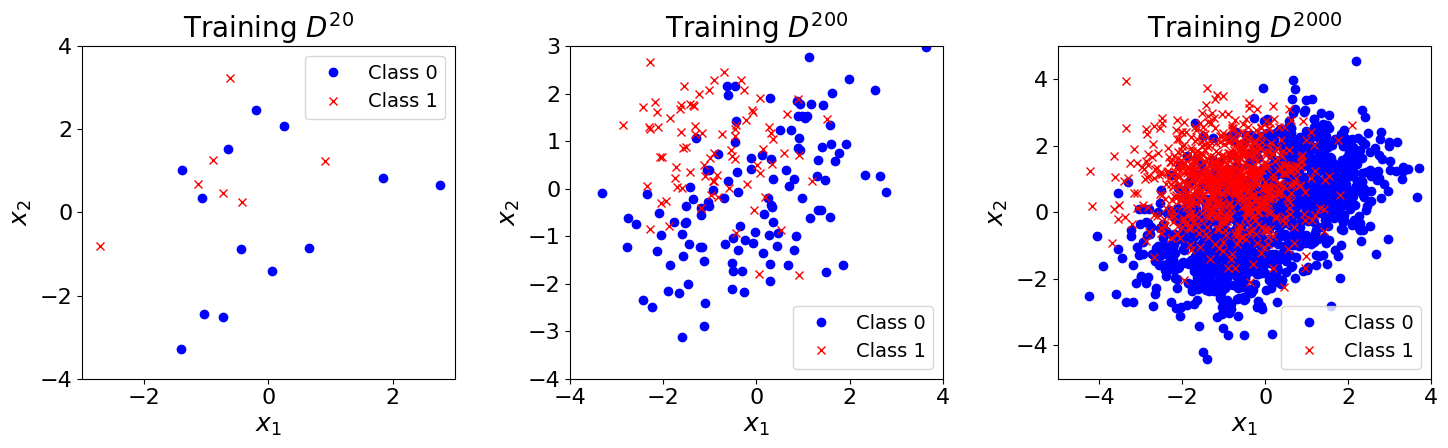

In [73]:
# Define distribution parameters: priors, gmm_a, mu, and Sigma
pdf_params = {
    'priors': np.array([0.6, 0.4]),
    'gmm_a': np.array([0.5, 0.5]),
    'mu': np.array([[-1, -1], [1, 1], [-1, 1], [1, -1]]),
    'Sigma': np.array([
        [[1, 0], [0, 1]],
        [[1, 0], [0, 1]],
        [[1, 0], [0, 1]],
        [[1, 0], [0, 1]]
    ])
}

# Number of training input samples for experiments
N_train = [20, 200, 2000]

# Create the figure and subplots with 1 row and 3 columns (since 1 subplot was empty)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Lists to store the generated samples and their labels
X_train = []
labels_train = []
N_labels_train = []

# Generate training data and plot it for different sizes
for t, N_t in enumerate(N_train):
    # Generate data for the current size
    X_t, labels_t = generate_q1_data(N_t, pdf_params)
    X_train.append(X_t)
    labels_train.append(labels_t)
    N_labels_train.append(np.array((sum(labels_t == 0), sum(labels_t == 1))))

    # Plot the data on the respective subplot
    ax[t].set_title(r"Training $D^{%d}$" % N_t)
    ax[t].plot(
        X_t[labels_t == 0, 0], X_t[labels_t == 0, 1], 'bo', label="Class 0"
    )
    ax[t].plot(
        X_t[labels_t == 1, 0], X_t[labels_t == 1, 1], 'rx', label="Class 1"
    )
    ax[t].set_xlabel(r"$x_1$")
    ax[t].set_ylabel(r"$x_2$")
    ax[t].legend()

    # Adjust axis limits to avoid overlap between smaller and larger datasets
    x1_lim = (floor(np.min(X_t[:, 0])), ceil(np.max(X_t[:, 0])))
    x2_lim = (floor(np.min(X_t[:, 1])), ceil(np.max(X_t[:, 1])))
    ax[t].set_xlim(x1_lim)
    ax[t].set_ylim(x2_lim)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

**Generate Validation Data and Plot**

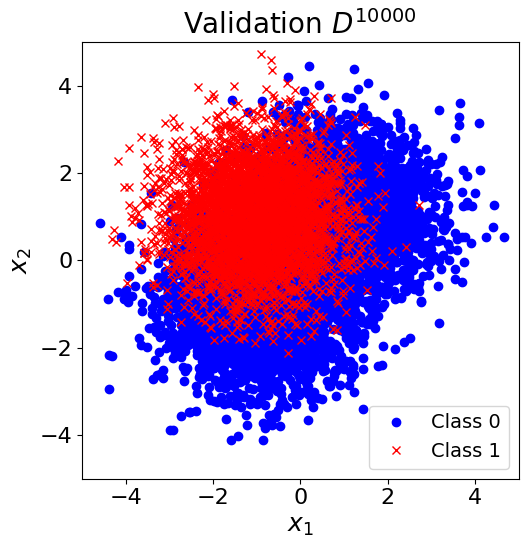

In [74]:
# Number of Validation Samples for experiment
N_valid = 10000

# Generate validation data
X_valid, labels_valid = generate_q1_data(N_valid, pdf_params)

# Count the number of samples per class in the validation set
N1_valid = np.array((sum(labels_valid == 0), sum(labels_valid == 1)))

# Create a single plot (no subplots) for the validation data
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the validation data
ax.set_title(r"Validation $D^{%d}$" % N_valid)
ax.plot(
    X_valid[labels_valid == 0, 0], X_valid[labels_valid == 0, 1], 'bo', label="Class 0"
)
ax.plot(
    X_valid[labels_valid == 1, 0], X_valid[labels_valid == 1, 1], 'rx', label="Class 1"
)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.legend()

# Set axis limits based on the data
x1_valid_lim = (floor(np.min(X_valid[:, 0])), ceil(np.max(X_valid[:, 0])))
x2_valid_lim = (floor(np.min(X_valid[:, 1])), ceil(np.max(X_valid[:, 1])))
ax.set_xlim(x1_valid_lim)
ax.set_ylim(x2_valid_lim)

# Keep axis proportions equal
ax.set_aspect('equal', adjustable='box')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

**Question 1: Part 1**<br>
**Calculate ERM Scores and Plot ROC Curve**

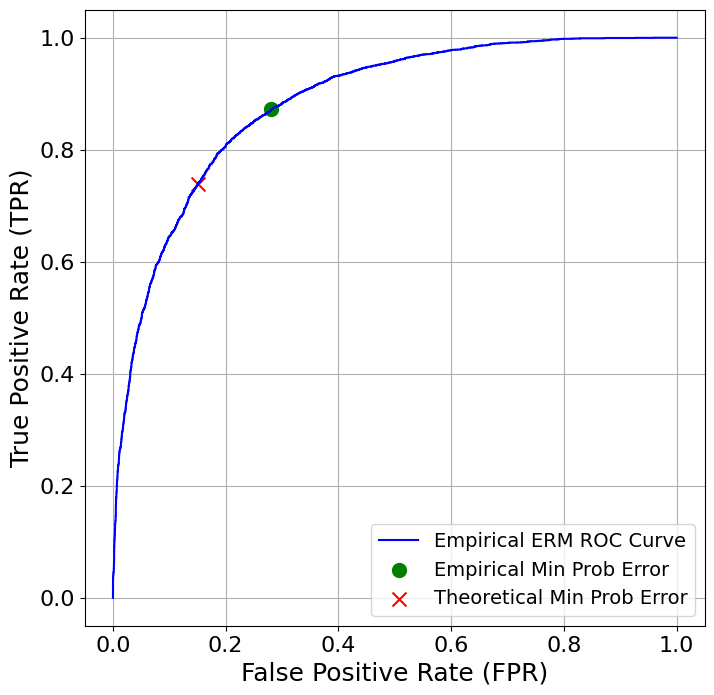

Empirical Min Prob Error for ERM = 0.1890
Empirical Min Gamma = 1.244
Theoretical Min Prob Error for ERM = 0.2166
Theoretical Gamma = 1.500


In [75]:
# Function to calculate ERM scores for given data and distribution parameters
def calculate_erm_scores(X, dist_params):
    class_0 = dist_params['gmm_a'][0] * mvn.pdf(X, dist_params['mu'][0], dist_params['Sigma'][0]) + \
              dist_params['gmm_a'][1] * mvn.pdf(X, dist_params['mu'][1], dist_params['Sigma'][1])
    class_1 = mvn.pdf(X, dist_params['mu'][2], dist_params['Sigma'][2])
    return np.log(class_1 + 1e-10) - np.log(class_0 + 1e-10)  # Adding tolerance for numerical stability

# Generate ERM scores for the validation dataset
erm_scores = calculate_erm_scores(X_valid, pdf_params)

# Calculate predictions based on ERM scores
predictions = (erm_scores >= 0).astype(int)

# Generate ROC curve data using validation labels and ERM scores
fpr, tpr, thresholds = roc_curve(labels_valid, erm_scores)
roc_erm = {'p10': fpr, 'p11': tpr}

# Calculate empirical probability of error based on ROC points and class priors
prob_error_empirical = roc_erm['p10'] * pdf_params['priors'][1] + \
                       (1 - roc_erm['p11']) * pdf_params['priors'][0]

# Find the optimal threshold by minimizing classification error
threshold_tuning = np.linspace(erm_scores.min(), erm_scores.max(), 500)
best_threshold = min(threshold_tuning, key=lambda t: np.mean((erm_scores >= t).astype(int) != labels_valid))

# Calculate the empirical gamma by normalizing the best threshold
mean_score, std_score = np.mean(erm_scores), np.std(erm_scores)
min_gamma_empirical = np.exp((best_threshold - mean_score) / std_score)

# Calculate the theoretical gamma based on class priors
theoretical_gamma = pdf_params['priors'][0] / pdf_params['priors'][1]
theoretical_threshold = np.log(theoretical_gamma)

# Find the closest threshold on the ROC curve to the theoretical gamma
closest_threshold_index = np.argmin(np.abs(thresholds - theoretical_threshold))

# Calculate the theoretical minimum probability of error
theoretical_error = (pdf_params['priors'][0] * (1 - tpr[closest_threshold_index]) +
                     pdf_params['priors'][1] * fpr[closest_threshold_index])

# Plot the ROC curve along with empirical and theoretical min error points
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr, label="Empirical ERM ROC Curve", color='blue')
ax.scatter(fpr[np.argmin(prob_error_empirical)], tpr[np.argmin(prob_error_empirical)],
           color='green', label="Empirical Min Prob Error", s=100, marker='o')
ax.scatter(fpr[closest_threshold_index], tpr[closest_threshold_index],
           color='red', label="Theoretical Min Prob Error", s=100, marker='x')
ax.set_xlabel("False Positive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
plt.grid(True)
plt.legend()
plt.show()

# Display final results for empirical and theoretical minimum errors and gamma
print(f"Empirical Min Prob Error for ERM = {np.min(prob_error_empirical):.4f}")
print(f"Empirical Min Gamma = {min_gamma_empirical:.3f}")
print(f"Theoretical Min Prob Error for ERM = {theoretical_error:.4f}")
print(f"Theoretical Gamma = {theoretical_gamma:.3f}")

**Question 2: Part 2** <br>
**Logistic Prediction and NLL (Binary Cross-Entropy) Function**

In [76]:
# Epsilon: Smallest positive floating value to avoid numerical instability
epsilon = 1e-7

# Define the logistic/sigmoid function
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

# Define the prediction function: L = 1 / (1 + np.exp(-X * w))
# X.dot(w) serves as inputs to the sigmoid, referred to as logits
def logistic_prediction_prob(X, w):
    logits = X.dot(w)  # Compute the logits
    return sigmoid(logits)  # Apply the sigmoid function

# Binary cross-entropy, equivalent to NLL (Negative Log-Likelihood)
def nll(labels, predictions):
    # Epsilon adjustment to prevent underflow or overflow
    predictions = np.clip(predictions, epsilon, 1 - epsilon)

    # Log probability for the negative class: log P(L=0 | x; theta)
    log_p0 = (1 - labels) * np.log(1 - predictions + epsilon)

    # Log probability for the positive class: log P(L=1 | x; theta)
    log_p1 = labels * np.log(predictions + epsilon)

    # NLL: Mean of the per-sample negative log-likelihoods
    return -np.mean(log_p0 + log_p1, axis=0)

**Compute Logistic Parameters (MLE of Parameter Theta)**

In [77]:
def compute_logistic_params(samples, labels):
    # Initialize theta0 with the correct dimensionality (including bias term)
    theta0 = np.random.rand(samples.shape[1])

    # Define the cost function to minimize NLL
    cost_fun = lambda w: nll(labels, logistic_prediction_prob(samples, w))

    # Use minimize function from SciPy to solve the optimization problem
    res = minimize(cost_fun, theta0, tol=1e-6)

    # Return the optimized parameter vector (theta)
    return res.x

**Logistic Classifier Results and Plot Decision Contours**

In [78]:
def report_logistic_classifier_results(ax, data, weights, labels, label_counts, phi=None):
    # Apply the phi transformation if provided
    transformed_data = phi.fit_transform(data) if phi else data

    predictions = logistic_prediction_prob(transformed_data, weights)

    # Predicted decisions based on the 0.5 threshold
    decisions = (predictions >= 0.5).astype(int)

    # Get classification metrics (TP, FP, TN, FN)
    logistic_metrics = get_binary_classification_metrics(decisions, labels, label_counts)

    # Calculate the probability of error
    prob_error = np.array([logistic_metrics['FPR'], logistic_metrics['FNR']]).T.dot(
        label_counts / data.shape[0]
    )

    # Plot decisions (Correct: blue/green, Incorrect: red)
    ax.plot(data[logistic_metrics['TN'], 0], data[logistic_metrics['TN'], 1], '^b', label="Correct Class 0")
    ax.plot(data[logistic_metrics['FP'], 0], data[logistic_metrics['FP'], 1], '^r', label="Incorrect Class 0")
    ax.plot(data[logistic_metrics['FN'], 0], data[logistic_metrics['FN'], 1], '+r', label="Incorrect Class 1")
    ax.plot(data[logistic_metrics['TP'], 0], data[logistic_metrics['TP'], 1], '+b', label="Correct Class 1")

    # Plot decision boundary grid
    xx, yy, Z = create_prediction_score_grid(
    (np.min(data[:, 0]) - 1, np.max(data[:, 0]) + 1),
    (np.min(data[:, 1]) - 1, np.max(data[:, 1]) + 1),
    lambda point: logistic_prediction_prob(phi.transform([point]) if phi else [point], weights)[0])
    cs = ax.contour(xx, yy, Z, levels=1, colors='k')

    # Set labels and title
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")

    return prob_error

Optional<br>
**Plot ERM Decision Boundaries Code**

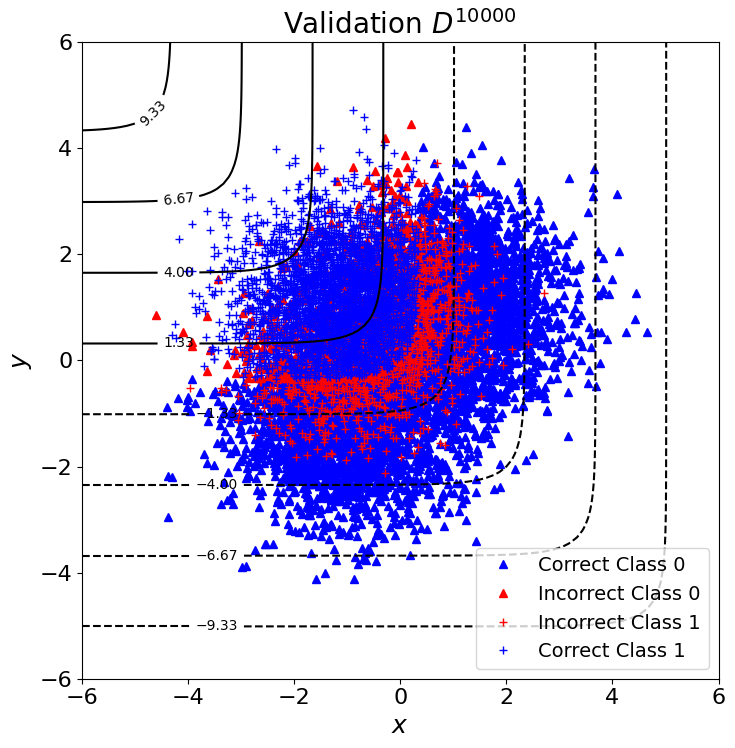

In [79]:
def plot_erm_decision_boundaries(ax, X, prediction_function, phi=None):
    """
    Plots ERM decision boundaries using a contour plot.
    """
    # Define axis bounds based on the input data
    bounds_X = (floor(np.min(X[:, 0])) - 1, ceil(np.max(X[:, 0])) + 1)
    bounds_Y = (floor(np.min(X[:, 1])) - 1, ceil(np.max(X[:, 1])) + 1)

    # Generate grid and corresponding discriminant scores
    xx, yy, Z = create_prediction_score_grid(bounds_X, bounds_Y, prediction_function, phi)

    # Define contour levels based on Z values
    contour_levels = np.linspace(np.min(Z), np.max(Z), 10)

    # Plot the decision boundaries with contour levels
    cs = ax.contour(xx, yy, Z, levels=contour_levels, colors='k')
    ax.clabel(cs, fontsize=10, inline=1)

# Ensure that class metrics are correctly computed and stored
class_metrics_map = get_binary_classification_metrics(predictions, labels_valid, N1_valid)

# Define a figure for the validation plot with decision boundaries
fig_disc_grid, ax_disc = plt.subplots(figsize=(8, 8))
ax_disc.set_title(r"Validation $D^{%d}$" % N_valid)

# Plot correct and incorrect predictions
ax_disc.plot(X_valid[class_metrics_map['TN'], 0], X_valid[class_metrics_map['TN'], 1], '^b', label="Correct Class 0")
ax_disc.plot(X_valid[class_metrics_map['FP'], 0], X_valid[class_metrics_map['FP'], 1], '^r', label="Incorrect Class 0")
ax_disc.plot(X_valid[class_metrics_map['FN'], 0], X_valid[class_metrics_map['FN'], 1], '+r', label="Incorrect Class 1")
ax_disc.plot(X_valid[class_metrics_map['TP'], 0], X_valid[class_metrics_map['TP'], 1], '+b', label="Correct Class 1")

# Set axis labels
ax_disc.set_xlabel(r"$x$")
ax_disc.set_ylabel(r"$y$")

# Call the plot function to draw decision boundaries
plot_erm_decision_boundaries(
    ax_disc,
    X_valid,
    discriminant_score_erm
)

# Set the aspect ratio and adjust axis limits to prevent skew
ax_disc.set_aspect('equal', adjustable='box')
ax_disc.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

**Logistic-Linear Model Optimization and Results**

Logistic-Linear Model Optimization Results for Different Training Subsets

Training Subset Size (N): 20; MLE for Model Parameters (w): [-1.3116299  -0.91956086  0.6101539 ]
Training set error for N=20 classifier is 0.300
Validation set error for N=20 classifier is 0.245

Training Subset Size (N): 200; MLE for Model Parameters (w): [-1.14618962 -0.86736636  1.03784857]
Training set error for N=200 classifier is 0.235
Validation set error for N=200 classifier is 0.235

Training Subset Size (N): 2000; MLE for Model Parameters (w): [-1.40153152 -0.94160397  0.99618381]
Training set error for N=2000 classifier is 0.227
Validation set error for N=2000 classifier is 0.232



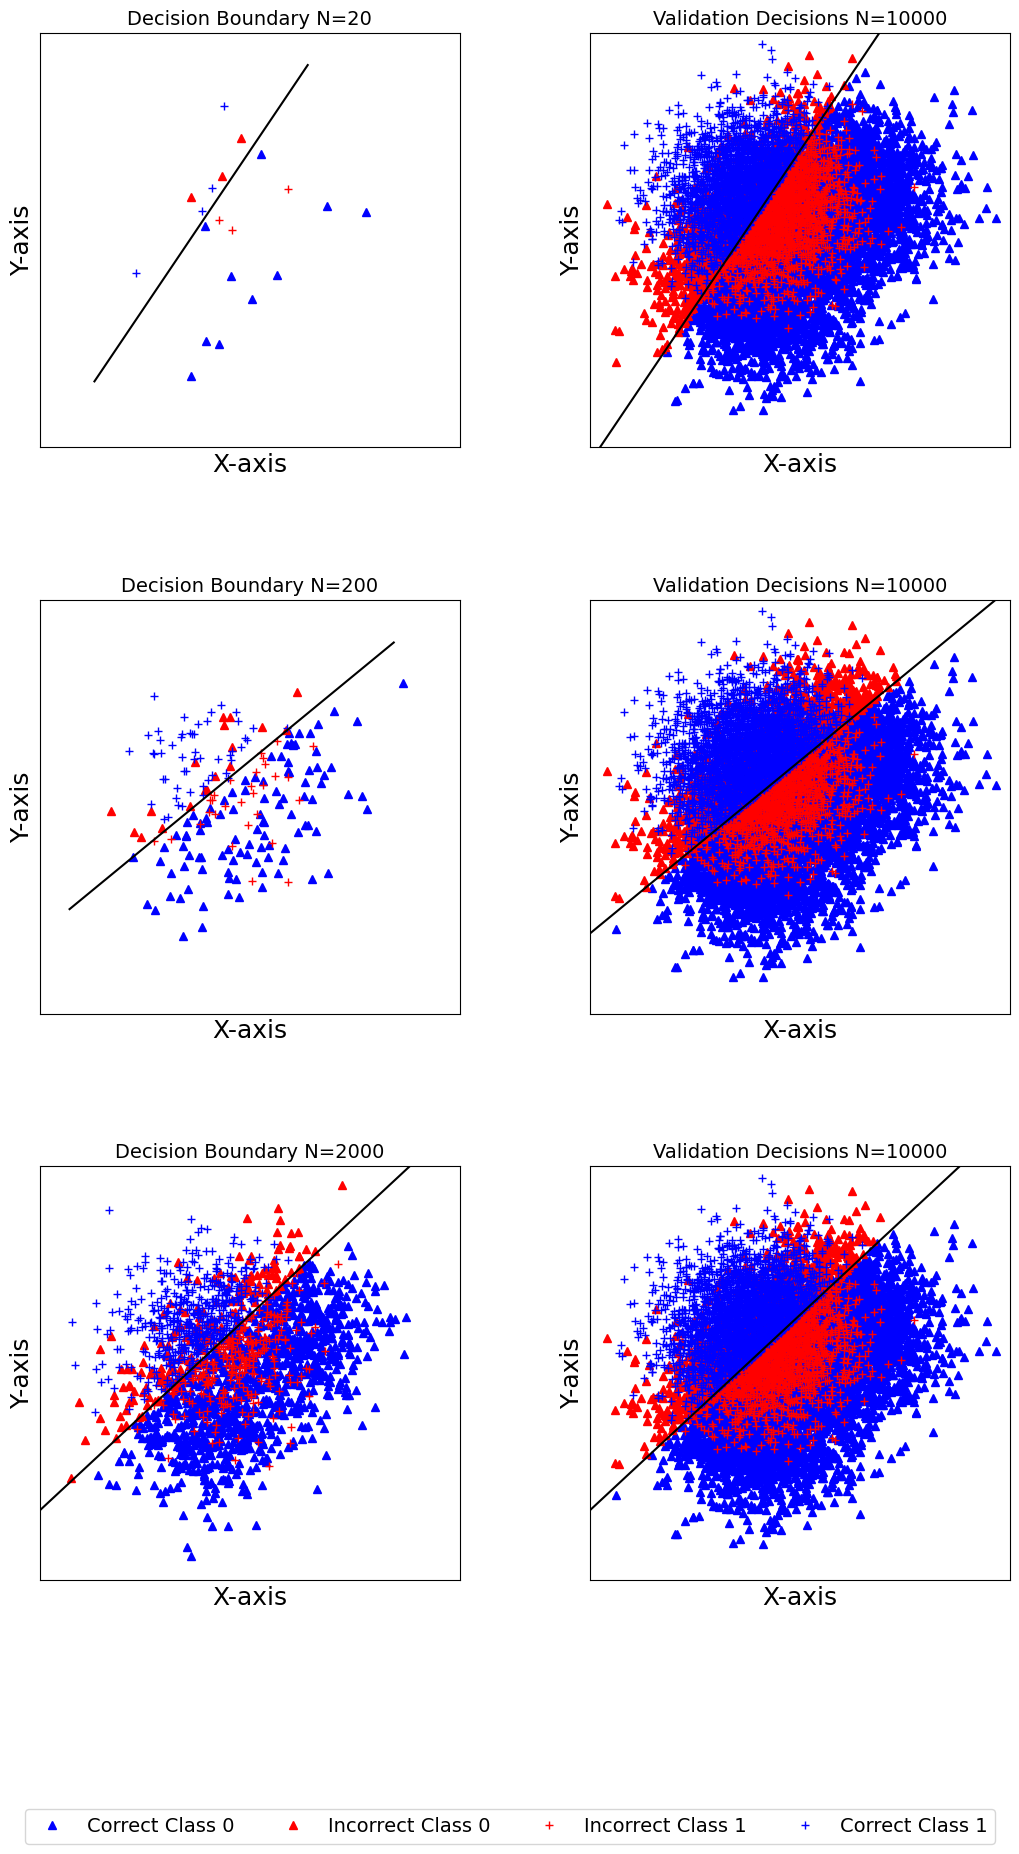

In [82]:
# Calculate the number of samples per class in the validation set
N_labels_valid = np.array([sum(labels_valid == 0), sum(labels_valid == 1)])

# Create subplots with increased figure size for better visibility
fig_linear, ax_linear = plt.subplots(3, 2, figsize=(12, 18))  # Adjusted size for better spacing

# Define the phi transformation to only include a bias column (degree 1 polynomial)
phi = PolynomialFeatures(degree=1)

print("Logistic-Linear Model Optimization Results for Different Training Subsets\n")

# Iterate over different training subsets and compute MLE parameters
for i, num_samples in enumerate(N_train):
    # Compute MLE parameters for the logistic-linear model
    w_mle = compute_logistic_params(phi.fit_transform(X_train[i]), labels_train[i])

    # Print the MLE parameters for the current training subset
    print(f"Training Subset Size (N): {num_samples}; MLE for Model Parameters (w): {w_mle}")

    # Report and plot results on the training set
    training_error = report_logistic_classifier_results(
        ax_linear[i, 0], X_train[i], w_mle, labels_train[i], N_labels_train[i], phi
    )
    print(f"Training set error for N={num_samples} classifier is {training_error:.3f}")

    # Set title and remove ticks for the training set plot
    ax_linear[i, 0].set_title(f"Decision Boundary N={num_samples}", fontsize=14)
    ax_linear[i, 0].set_xticks([])
    ax_linear[i, 0].set_yticks([])

    # Report and plot results on the validation set
    prob_error = report_logistic_classifier_results(
        ax_linear[i, 1], X_valid, w_mle, labels_valid, N_labels_valid, phi
    )
    print(f"Validation set error for N={num_samples} classifier is {prob_error:.3f}\n")

    # Set title and remove ticks for the validation set plot
    ax_linear[i, 1].set_title(f"Validation Decisions N={N_valid}", fontsize=14)
    ax_linear[i, 1].set_xticks([])
    ax_linear[i, 1].set_yticks([])

# Set axis limits for all plots based on the validation set limits
plt.setp(ax_linear, xlim=x1_valid_lim, ylim=x2_valid_lim)

# Adjust layout to prevent overlap between subplots
plt.tight_layout(pad=3.0)  # Increased padding between subplots

# Add a shared legend below the plots (outside the figure)
handles, labels = ax_linear[0, 1].get_legend_handles_labels()
fig_linear.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

# Display the plots
plt.show()

**Logistic-Quadratic Model Optimization and Results**

Second-order optimization of the NLL loss for a logistic-quadratic model applied to different training subsets

Training Subset Size (N): 20; MLE for Model Parameters (w): [-1.13477422 -1.16536271  1.15080551 -0.03617655  0.48455116 -0.260896  ]
Training set error for N=20 classifier is 0.400
Validation set error for N=20 classifier is 0.279

Training Subset Size (N): 200; MLE for Model Parameters (w): [-0.36386018 -0.76915305  0.91471439 -0.19117076 -0.6910404  -0.22288765]
Training set error for N=200 classifier is 0.210
Validation set error for N=200 classifier is 0.194

Training Subset Size (N): 2000; MLE for Model Parameters (w): [-0.61993337 -0.94406928  0.93077323 -0.21925547 -0.51445597 -0.20085655]
Training set error for N=2000 classifier is 0.202
Validation set error for N=2000 classifier is 0.196



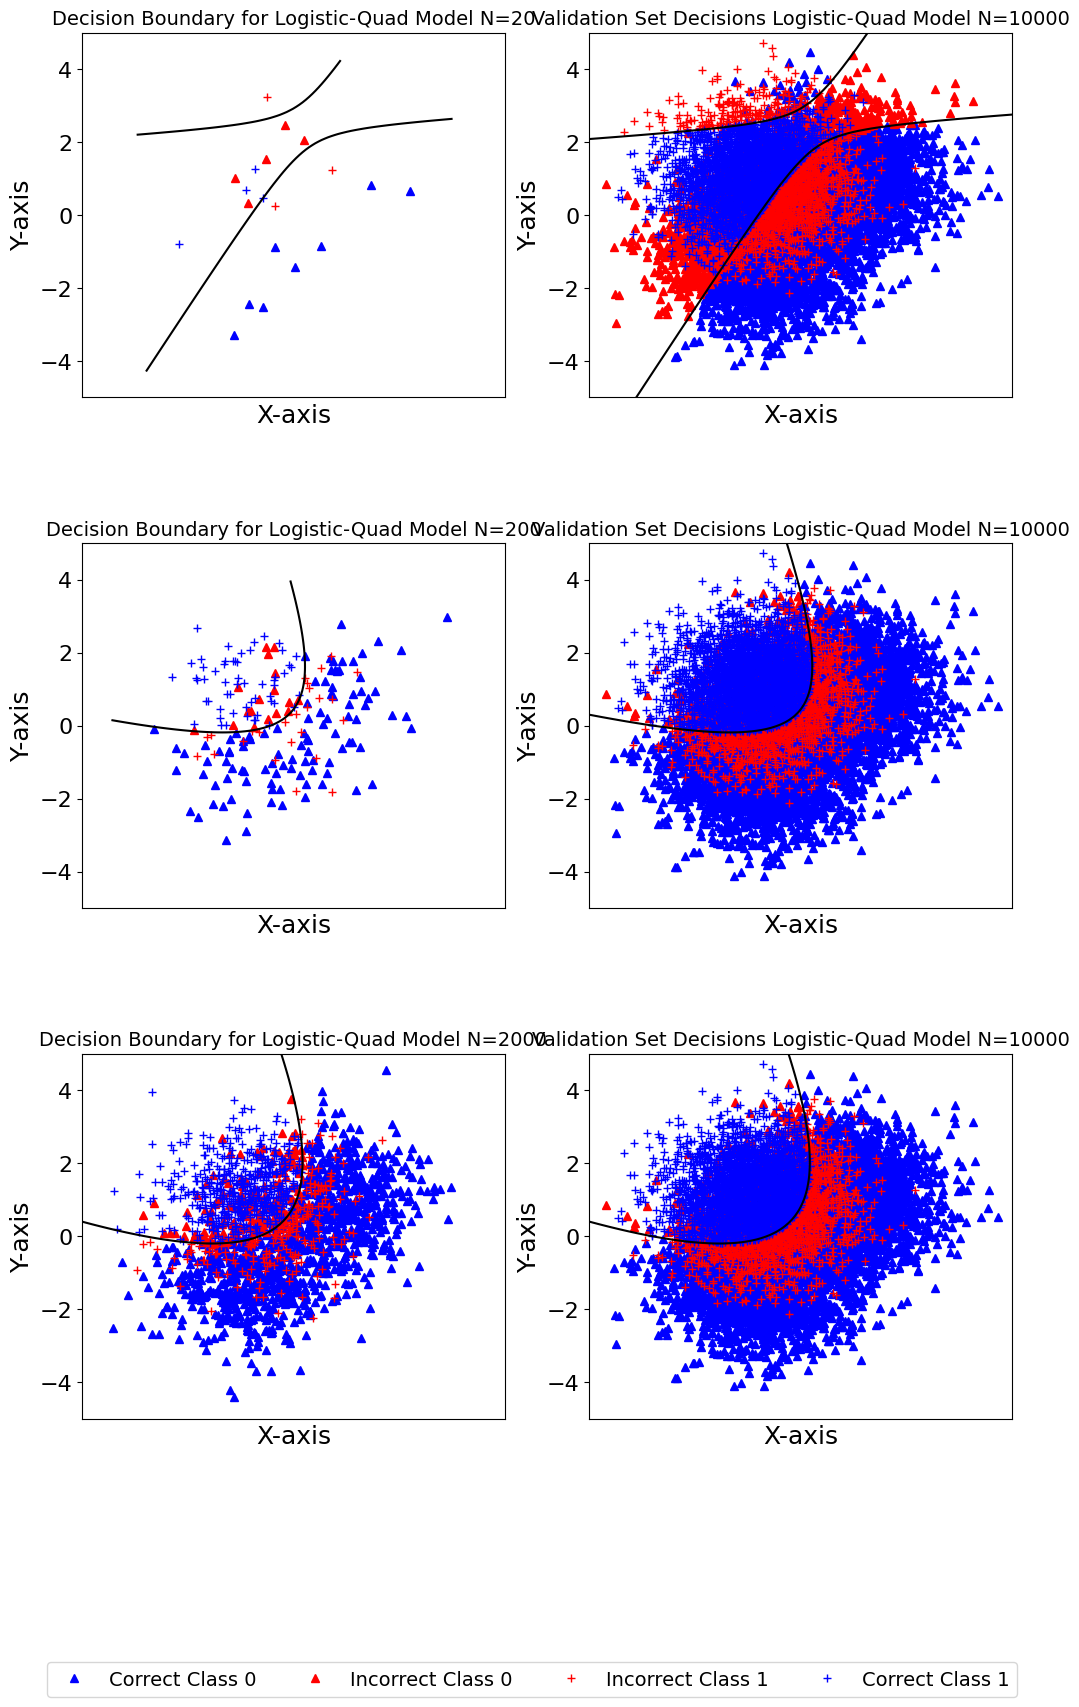

In [81]:
# Create subplots for logistic-quadratic model results with increased figure size
fig_quad, ax_quad = plt.subplots(3, 2, figsize=(12, 18))  # Increased size for better spacing

# Define the phi transformation for quadratic terms
phi = PolynomialFeatures(degree=2)

print("Second-order optimization of the NLL loss for a logistic-quadratic model applied to different training subsets\n")

# Iterate over different training subsets
for i, num_samples in enumerate(N_train):
    # Compute MLE for logistic-quadratic model parameters
    w_mle = compute_logistic_params(phi.fit_transform(X_train[i]), labels_train[i])

    # Print the MLE parameters
    print(f"Training Subset Size (N): {num_samples}; MLE for Model Parameters (w): {w_mle}")

    # Report and plot results for the training set
    training_error = report_logistic_classifier_results(
        ax_quad[i, 0], X_train[i], w_mle, labels_train[i], N_labels_train[i], phi
    )
    print(f"Training set error for N={num_samples} classifier is {training_error:.3f}")

    # Set the title for the training plot
    ax_quad[i, 0].set_title(f"Decision Boundary for Logistic-Quad Model N={num_samples}", fontsize=14)
    ax_quad[i, 0].set_xticks([])

    # Report and plot results for the validation set
    prob_error = report_logistic_classifier_results(
        ax_quad[i, 1], X_valid, w_mle, labels_valid, N_labels_valid, phi
    )
    print(f"Validation set error for N={num_samples} classifier is {prob_error:.3f}\n")

    # Set the title for the validation plot
    ax_quad[i, 1].set_title(f"Validation Set Decisions Logistic-Quad Model N={N_valid}", fontsize=14)
    ax_quad[i, 1].set_xticks([])

# Set consistent axis limits across all plots based on the validation set
plt.setp(ax_quad, xlim=x1_valid_lim, ylim=x2_valid_lim)

# Adjust layout to avoid overlap
plt.subplots_adjust(hspace=0.4)  # Increased spacing between plots

# Add a legend for all plots, positioned below the figure
handles, labels = ax_quad[0, 1].get_legend_handles_labels()
fig_quad.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4)

# Display the plots
plt.show()